<a href="https://colab.research.google.com/github/savitskaya-om/python/blob/main/project/PROJECT_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
from sklearn.metrics import f1_score

**Load Data**

In [2]:
!git clone https://github.com/Kokkalo4/Kaggle-SF-Salaries 

Cloning into 'Kaggle-SF-Salaries'...
remote: Enumerating objects: 19, done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 19
Unpacking objects: 100% (19/19), done.


In [3]:
sal = pd.read_csv("Kaggle-SF-Salaries/Salaries.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,4,5,6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Overview**

In [4]:
sal.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [5]:
sal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148654 entries, 0 to 148653
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                148654 non-null  int64  
 1   EmployeeName      148654 non-null  object 
 2   JobTitle          148654 non-null  object 
 3   BasePay           148049 non-null  object 
 4   OvertimePay       148654 non-null  object 
 5   OtherPay          148654 non-null  object 
 6   Benefits          112495 non-null  object 
 7   TotalPay          148654 non-null  float64
 8   TotalPayBenefits  148654 non-null  float64
 9   Year              148654 non-null  int64  
 10  Notes             0 non-null       float64
 11  Agency            148654 non-null  object 
 12  Status            38119 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 14.7+ MB


In [6]:
sal.describe()

,Id,TotalPay,TotalPayBenefits,Year,Notes
count,148654.000000,148654.000000,148654.000000,148654.000000,0.0
mean,74327.500000,74768.321972,93692.554811,2012.522643,NaN
std,42912.857795,50517.005274,62793.533483,1.117538,NaN
min,1.000000,-618.130000,-618.130000,2011.000000,NaN
25%,37164.250000,36168.995000,44065.650000,2012.000000,NaN
50%,74327.500000,71426.610000,92404.090000,2013.000000,NaN
75%,111490.750000,105839.135000,132876.450000,2014.000000,NaN
max,148654.000000,567595.430000,567595.430000,2014.000000,NaN


In [7]:
sal.describe(include = ['O'])

,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,Agency,Status
count,148654,148654,148049.0,148654.0,148654.0,112495.0,148654,38119
unique,110811,2159,109900.0,66555.0,84968.0,99635.0,1,2
top,Kevin Lee,Transit Operator,0.0,0.0,0.0,0.0,San Francisco,FT
freq,13,7036,875.0,66103.0,35218.0,1053.0,148654,22334


**Clean data**

Типы данных и неинформативные данные 

In [8]:
# convert numeric columns to float, text column to string instead of object.
sal[['BasePay', 'OvertimePay', 'OtherPay', 'Benefits']] = sal[['BasePay', 'OvertimePay', 'OtherPay', 'Benefits']].apply(pd.to_numeric, errors='coerce')
sal[['EmployeeName', 'JobTitle']] = sal[['EmployeeName', 'JobTitle']].astype('string', errors='ignore')
sal.Status = sal.Status.fillna("empty")

# convert year column to datetime type
sal['Year'] = pd.to_datetime(sal.Year, format='%Y').dt.year

# drop ['Notes'] columns as there are many missing values and column 'Agency' as it is not informative (contains just one unique value)
sal.drop(columns = ['Notes','Agency'], inplace=True)

In [9]:
sal.dtypes

Id                    int64
EmployeeName         string
JobTitle             string
BasePay             float64
OvertimePay         float64
OtherPay            float64
Benefits            float64
TotalPay            float64
TotalPayBenefits    float64
Year                  int64
Status               object
dtype: object

In [10]:
#check whether there are rows with missing values in 'TotalPay' column (not informative)
sal[sal.TotalPay == 0].describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
count,368.000000,76.0,364.0,364.0,361.000000,368.0,368.000000,368.000000
mean,109608.964674,0.0,0.0,0.0,6795.511856,0.0,6666.249402,2013.057065
std,18735.983397,0.0,0.0,0.0,2481.110854,0.0,2627.268462,0.489123
min,36157.000000,0.0,0.0,0.0,-33.890000,0.0,-33.890000,2011.000000
25%,106758.750000,0.0,0.0,0.0,7959.180000,0.0,7959.180000,2013.000000
50%,106850.500000,0.0,0.0,0.0,7959.180000,0.0,7959.180000,2013.000000
75%,106942.250000,0.0,0.0,0.0,7959.180000,0.0,7959.180000,2013.000000
max,148653.000000,0.0,0.0,0.0,8308.870000,0.0,8308.870000,2014.000000


In [11]:
#save part of the dataset with non-zero 'TotalPayBenefits' and  zero 'TotalPay' for potential separate analysis 
benefits_only = sal[(sal.TotalPay == 0) & (sal.TotalPayBenefits != 0)]
print(f"There are {len(benefits_only)} rows with non-zero 'TotalPayBenefits' and  zero 'TotalPay'")
benefits_only.head()

There are 338 rows with non-zero 'TotalPayBenefits' and  zero 'TotalPay'


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Status
70877,70878,Roland Baylon,Deputy Court Clerk II,0.0,0.0,0.0,3728.05,0.0,3728.05,2012,empty
70927,70928,Felecia Phillips,Registered Nurse,0.0,0.0,0.0,3618.13,0.0,3618.13,2012,empty
70928,70929,Robert Giannini,Painter,0.0,0.0,0.0,3614.56,0.0,3614.56,2012,empty
70932,70933,Nelly Kuan,Senior Eligibility Worker,0.0,0.0,0.0,3610.32,0.0,3610.32,2012,empty
70933,70934,William Mathews,Transit Power Line Worker,0.0,0.0,0.0,3608.42,0.0,3608.42,2012,empty


In [12]:
#remove rows with zero 'TotalPay' values from main dataframe
sal.drop(sal[sal.TotalPay == 0].index, inplace = True)

Пропущенные значения

In [13]:
print(f"sal.BasePay null values: {sal.BasePay.isnull().sum()}\nsal.OvertimePay null values: {sal.OvertimePay.isnull().sum()}\n \
sal.OtherPay null values: {sal.OtherPay.isnull().sum()}\nsal.Benefits null values: {sal.Benefits.isnull().sum()}\nsal.TotalPayBenefits null values: {sal.TotalPayBenefits.isnull().sum()}")

sal.BasePay null values: 317
sal.OvertimePay null values: 0
 sal.OtherPay null values: 0
sal.Benefits null values: 36156
sal.TotalPayBenefits null values: 0


In [14]:
#fill missing "BasePay" values 
sal.loc[sal.BasePay.isnull(),"BasePay"] = sal.loc[sal.BasePay.isnull(), "TotalPay"] - sal.loc[sal.BasePay.isnull(),"OvertimePay"] - sal.loc[sal.BasePay.isnull(), "OtherPay"]
#fill missing "Benefits" values 
sal.loc[sal.Benefits.isnull(),"Benefits"] = sal.loc[sal.Benefits.isnull(), "TotalPayBenefits"] - sal.loc[sal.Benefits.isnull(),"TotalPay"]

In [15]:
sal.describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
count,148286.000000,148286.000000,148286.000000,148286.000000,148286.000000,148286.000000,148286.000000,148286.000000
mean,74239.942314,66217.654219,5078.495624,3657.723984,18954.653363,74953.873827,93908.527191,2012.521317
std,42919.899896,42813.312492,11465.676891,8064.453244,17175.189711,50441.977909,62721.241666,1.118341
min,1.000000,-166.010000,-0.010000,-7058.590000,-13.800000,-618.130000,-618.130000,2011.000000
25%,37075.250000,33272.910000,0.000000,0.000000,0.000000,36679.020000,44691.035000,2012.000000
50%,74171.500000,64957.515000,0.000000,819.535000,23373.810000,71553.000000,92571.480000,2013.000000
75%,111530.750000,94691.010000,4680.157500,4254.895000,33492.905000,105967.057500,133004.167500,2014.000000
max,148654.000000,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,567595.430000,2014.000000


In [16]:
print(f"NaN values in modified dataset:\n{sal.isnull().sum()}")

NaN values in modified dataset:
Id                  0
EmployeeName        0
JobTitle            0
BasePay             0
OvertimePay         0
OtherPay            0
Benefits            0
TotalPay            0
TotalPayBenefits    0
Year                0
Status              0
dtype: int64


Дубликаты

In [17]:
print(f"There are {sal.duplicated().sum()} duplicated values in the dataset")

There are 0 duplicated values in the dataset


**Data Analysis**

Выбросы

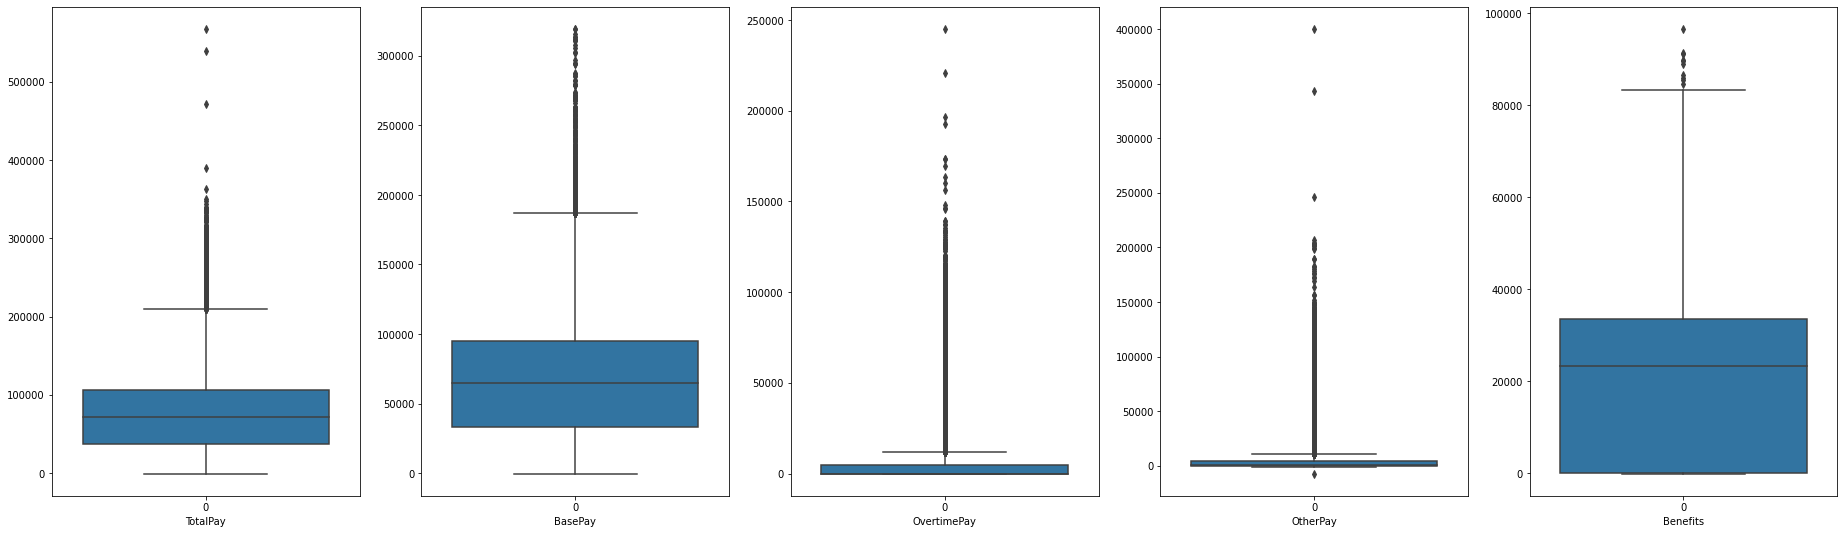

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(32, 9))

sns.boxplot(data = sal['TotalPay'], ax=axes[0]).set(xlabel='TotalPay')
sns.boxplot(data = sal['BasePay'], ax=axes[1]).set(xlabel='BasePay')
sns.boxplot(data = sal['OvertimePay'], ax=axes[2]).set(xlabel='OvertimePay')
sns.boxplot(data = sal['OtherPay'], ax=axes[3]).set(xlabel='OtherPay')
sns.boxplot(data = sal['Benefits'], ax=axes[4]).set(xlabel='Benefits')
plt.show()

In [19]:
# outliers are values greater than (Q3+1.5*IQR)
Q1 = np.percentile(sal['TotalPay'], 25, interpolation = 'midpoint')
Q3 = np.percentile(sal['TotalPay'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1

In [20]:
# Upper bound
upper = np.where(sal['TotalPay'] >= (Q3+1.5*IQR))
# lower bound
lower = np.where(sal['TotalPay'] <= (Q1-1.5*IQR))

In [21]:
print (f"В датасете всего {sal.iloc[upper].Id.count() + sal.iloc[lower].Id.count()} выбросов. Оставим пока как есть и попробуем проанализировать выбросы в разрезе по профессиям")

В датасете всего 1304 выбросов. Оставим пока как есть и попробуем проанализировать выбросы в разрезе по профессиям


Добавим поле 'Profession', значения в котором будут определяться на основании  'JobTitle'

In [22]:
sal.JobTitle = sal.JobTitle.str.lower()

In [23]:
sal["Profession"] = "TBD"

In [24]:
print(f"Всего в датасете {sal['JobTitle'].nunique()} уникальных Job Titles.\n30 наиболее частых:")
sal['JobTitle'].value_counts().head(25)

Всего в датасете 1633 уникальных Job Titles.
30 наиболее частых:


transit operator                9381
special nurse                   5788
registered nurse                4953
custodian                       3208
firefighter                     3147
recreation leader               2660
deputy sheriff                  2608
public svc aide-public works    2516
police officer 3                2417
patient care assistant          1944
public service trainee          1655
attorney (civil/criminal)       1502
police officer                  1472
porter                          1464
general laborer                 1399
gardener                        1183
police officer 2                1141
parking control officer         1132
library page                    1107
senior clerk                    1063
senior clerk typist             1049
sergeant 3                      1047
clerk                            980
eligibility worker               980
emt/paramedic/firefighter        917
Name: JobTitle, dtype: Int64

Сделаем разметку Job Title -> Profession для наиболее распространенных job titles из списка выше  

In [25]:
profession_dict = {"police":"police", "fire" : "fire", "medical": "medicine", "transit": "transportation", "nurs":"medicine", "patient care assistant": "medicine", 
                   "custodian": "custodian", "attorney": "attorney", "sheriff": "sheriff", "clerk": "clerk", "public svc" :"public service jobs", 
                   "public service":"public service jobs", "sergeant": "police", "recreation": "recreation", "general laborer":"general laborer","librar":"library", "porter":"porter", "gardener":"gardener"} 

In [26]:
def def_prof(): 
  """function which fills in column 'Profession' in the dataset"""
  for k,v in profession_dict.items():
      sal.loc[sal['JobTitle'].str.contains(k), "Profession"] = v

In [27]:
def_prof()

Проверим, какие Job Title осталичь неразмеченными

In [28]:
sal.loc[sal.Profession == "TBD", 'JobTitle'].value_counts().head(30)

parking control officer                1132
eligibility worker                      980
stationary engineer                     885
senior eligibility worker               875
protective services worker              822
museum guard                            820
senior administrative analyst           805
school crossing guard                   712
truck driver                            707
food service worker                     700
engineer                                629
ps aide to prof                         626
publ svc aide-asst to prof              574
manager iii                             568
automotive mechanic                     562
mental health rehabilitation worker     559
physician specialist                    528
senior physician specialist             526
manager ii                              517
manager i                               512
pr administrative analyst               511
deputy probation officer                511
assoc engineer                  

In [29]:
profession_dict.update({"publ svc": "public service jobs", "ps aide": "public service jobs", "eligibility worker": "eligibility worker", "engineer":"engineer"})
def_prof()

In [30]:
print(f"Размечено {sal[~(sal.Profession == 'TBD')].Profession.count()} строк, не размечено -   {sal[sal.Profession == 'TBD'].Profession.count()} ")

Размечено 87671 строк, не размечено -   60615 


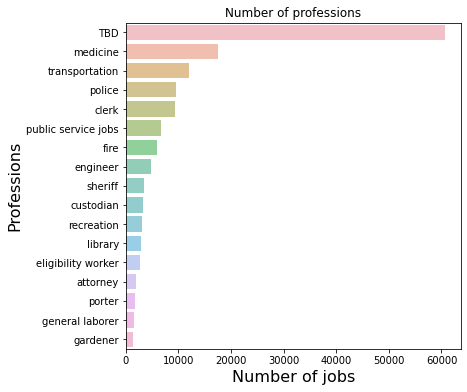

In [31]:
plt.figure(figsize=(6,6))
sectors = sal['Profession'].value_counts()[0:30]
sns.barplot(y=sectors.index, x=sectors.values, alpha=0.6)
plt.xlabel('Number of jobs', fontsize=16)
plt.ylabel("Professions", fontsize=16)
plt.title("Number of professions")
plt.show();

Видно, что осталось много строк, где профессия не определена. Проанализируем, нужна ли дальнейшая грануляция для этих данных

Для начала проверим, менялось ли распределение зарплат от года к году в 2011 - 2014, чтобы понять нужно ли проводить анализ в разрезе профессия+год или можем анализировать просто по профессиям для упрощения

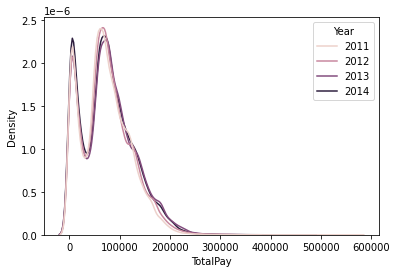

In [32]:
sns.kdeplot(data=sal, x="TotalPay", hue="Year")

Видно, что распредение от года меняется несильно, поэтому для простоты анализ зарплаты в зависимости от профессии будем проводить без разбивки по годам. Также из графика плотности распределения видно, что распределение величины TotalPay имеет два пика

Прежде чем продолжать анализ в разрезе по профессиям, проверим гипотезу: левый пик - это распределение зарплат для Part-time работников, а правый пик - для Full-time (поле Status)

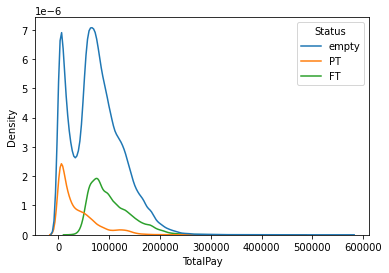

In [33]:
sns.kdeplot(data=sal, x="TotalPay", hue="Status")

В датасете много строк, у которых поле Status не заполнено. Видно, что поле появилось только в 2014 году:

In [34]:
sal[["Status","Year"]].value_counts()

Status  Year
empty   2013    37318
        2012    36741
        2011    36156
FT      2014    22334
PT      2014    15737
dtype: int64

Теперь посмотрим распределение зарплаты в разбивке по профессиям и годам

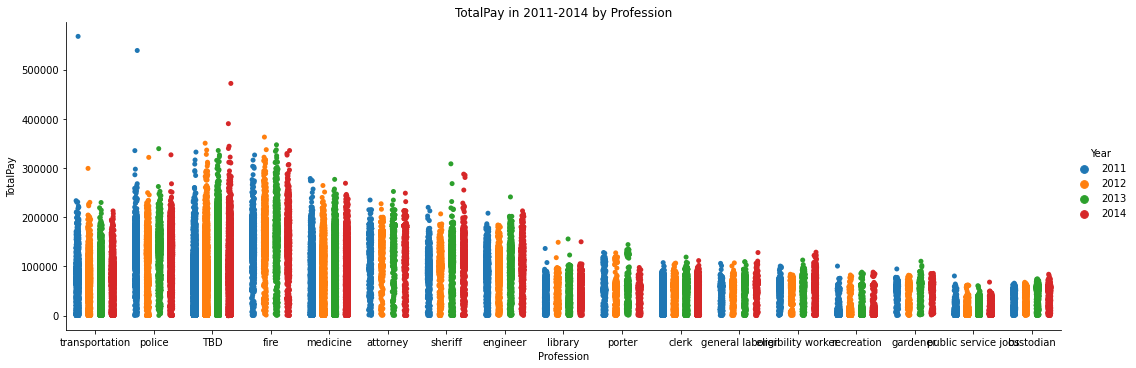

In [35]:
sns.catplot(x="Profession", y="TotalPay",  data=sal, aspect = 3, hue = "Year", dodge=True).set(title='TotalPay in 2011-2014 by Profession')

Видим большие выбросы в сфере transportation, police в 2011 году и TBD (не определено) в 2014. Удалим 3 эти строки из датасета, чтобы не искажать статистику

In [36]:
sal.nlargest(3, 'TotalPay').sort_values('TotalPay')

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Status,Profession
110531,110532,David Shinn,deputy chief 3,129150.01,0.00,342802.63,38780.04,471952.64,510732.68,2014,PT,TBD
1,2,GARY JIMENEZ,captain iii (police department),155966.02,245131.88,137811.38,0.00,538909.28,538909.28,2011,empty,police
0,1,NATHANIEL FORD,general manager-metropolitan transit authority,167411.18,0.00,400184.25,0.00,567595.43,567595.43,2011,empty,transportation


In [37]:
sal = sal[~(sal.Id.isin(sal.nlargest(3, 'TotalPay').Id))]

Построим гистограммы для величины TotalPay для разных профессий

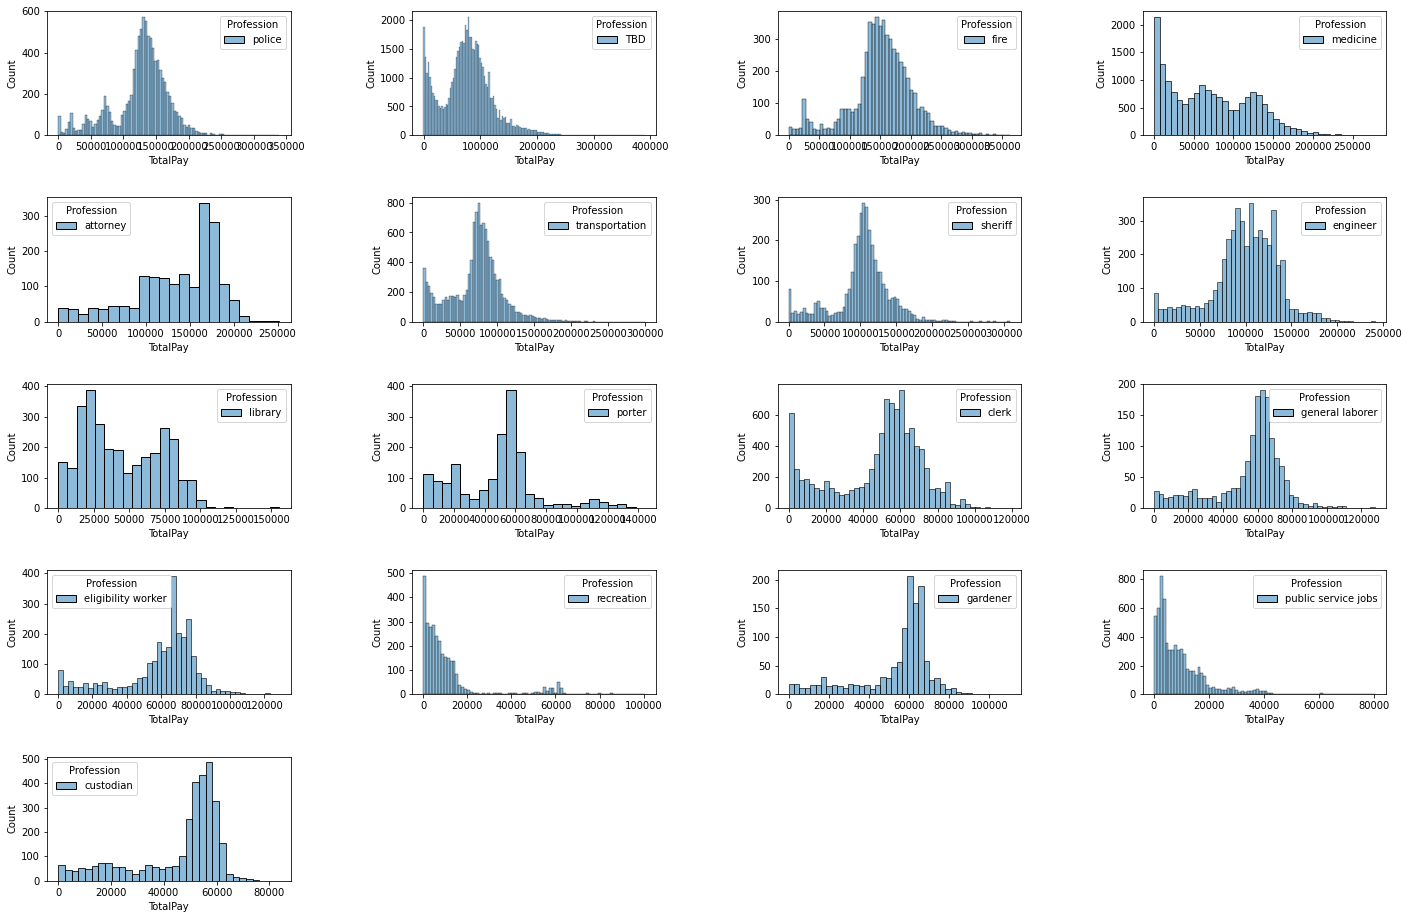

In [38]:
plt.figure(figsize=(24,16))
for i, prof in enumerate(sal.Profession.unique()):   
  plt.subplot(5,4,i+1)
  sns.histplot(data=sal.loc[sal.Profession.str.contains(prof)], x="TotalPay", hue="Profession")
plt.subplots_adjust(wspace=0.5,hspace=0.5)

Видно, что величина TotalPay для данных, у которых Profession не определено (="TBD"), принимает значение в широком диапазоне, поэтому продолжим определение Profession

Ниже суммируем статистическую информацию в табличном виде

In [39]:
sal_wide = pd.pivot_table (sal, index = 'Id', values = 'TotalPay', columns = 'Profession',  aggfunc=np.sum)
sal_wide.describe()

Profession,TBD,attorney,clerk,custodian,eligibility worker,engineer,fire,gardener,general laborer,library,medicine,police,porter,public service jobs,recreation,sheriff,transportation
count,60614.000000,1840.000000,9321.000000,3208.000000,2719.000000,4747.000000,5838.000000,1270.000000,1582.000000,2974.000000,17509.000000,9573.000000,1694.000000,6740.000000,3072.000000,3532.000000,12050.000000
mean,75938.982817,135990.361413,48251.942425,45533.580916,59292.141188,99437.800011,151943.666694,53917.547331,55331.393508,44669.454536,70547.555755,126635.687769,48247.693129,9468.735335,11613.496839,102592.510906,71683.049849
std,44801.125213,49646.944200,23719.213171,17123.862850,22294.659679,35971.827658,51034.576876,18767.650483,20202.749938,27276.249539,52624.917201,42664.343060,27324.754018,9410.494608,16296.155749,38214.971678,35328.094060
min,-618.130000,13.350000,4.750000,41.950000,59.420000,162.660000,5.800000,21.830000,14.260000,17.780000,3.280000,21.980000,81.740000,10.670000,15.500000,24.760000,0.300000
25%,49143.132500,105170.375000,35193.300000,37628.810000,52917.680000,82038.225000,130373.125000,50063.670000,50156.105000,22223.055000,21183.260000,112957.580000,23782.510000,2813.662500,2625.360000,91406.965000,53983.605000
50%,76411.010000,148434.400000,54502.010000,52498.850000,66066.390000,102937.100000,153828.885000,60218.975000,60677.555000,39436.620000,64622.790000,132734.930000,53111.570000,6650.825000,6423.725000,105981.900000,75106.750000
75%,100552.997500,175970.350000,64237.110000,56933.155000,72952.375000,123747.060000,181509.412500,64680.455000,66596.430000,70729.742500,114818.610000,152236.830000,59690.235000,12886.640000,12247.205000,121882.192500,90493.890000
max,390111.980000,252221.060000,118781.480000,83846.770000,128779.860000,241126.970000,362844.660000,110355.700000,128032.170000,155687.410000,278569.210000,339282.070000,144228.560000,80393.020000,100515.400000,308434.840000,299162.310000


Проанализируем  подмножество нашего датасета, в котором пока не определено поле Profession.

Boxplot для подмножества датасета, у которого Profession остался неопределенным

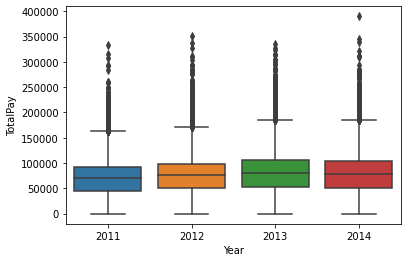

In [40]:
ax = sns.boxplot(x="Year", y="TotalPay", data=sal[(sal.Profession == "TBD")])
plt.show()

Шаг1. Выбросы

In [41]:
Q1_TBD = np.percentile(sal.loc[sal.Profession == "TBD", 'TotalPay'], 25, interpolation = 'midpoint')
Q3_TBD = np.percentile(sal.loc[sal.Profession == "TBD", 'TotalPay'], 75, interpolation = 'midpoint')
IQR_TBD = Q3_TBD - Q1_TBD

In [42]:
sal.loc[(sal.TotalPay >= (Q3_TBD+1.5*IQR_TBD))& (sal.Profession == 'TBD'),"JobTitle"].value_counts().head(30)

senior physician specialist         170
lieutenant 3                        155
head atty, civil & criminal         115
inspector 3                         108
captain 3                            96
manager viii                         75
dep dir iv                           56
captain, emergency med svcs          54
anesthetist                          49
manager vii                          47
supervising physician spec           41
dep dir v                            41
manager vi                           33
physician specialist                 23
dept head iii                        20
deputy chief 3                       19
commander 3                          18
dept head v                          17
supervising physician specialist     15
incident support specialist          15
dept head iv                         15
eng/arch/landscape arch sr           15
deputy director v                    14
project manager 4                    14
dep dir iii                          14


In [43]:
profession_dict.update({"atty": "attorney", "physician": "physician", "anesthetist": "medicine", "engineer": "engineer", "emergency med": "medicine", "lieutenant":"police",
                        "captain": "captain", "inspector": "inspector", "dep": "executives", "manager":"manager", "deputy": "executives", "head": "executives"})
def_prof()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Шаг 2. Хвост распределения

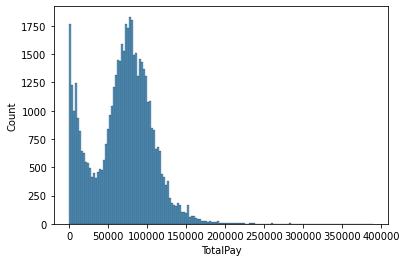

In [44]:
sns.histplot(data=sal.loc[sal.Profession.str.contains("TBD")], x="TotalPay")

In [45]:
sal.loc[(sal.Profession.str.contains("TBD"))&(sal.TotalPay>70000), "JobTitle"].value_counts().head(30) #greater than average

protective services worker        684
senior administrative analyst     638
automotive mechanic               478
truck driver                      454
pr administrative analyst         437
asst engr                         415
public safetycomm disp            405
stationary eng, sewage plant      390
electronic maintenance tech       389
senior personnel analyst          347
psychiatric social worker         338
electrician                       318
painter                           314
administrative analyst            297
is business analyst-principal     263
eng/arch/landscape arch sr        262
automotive service worker         251
carpenter                         233
parking control officer           232
accountant iii                    223
program specialist                221
is business analyst-senior        218
plumber                           218
senior social worker              216
automotive machinist              216
utility plumber                   203
hospital eli

In [46]:
profession_dict.update({"protective services worker": "protective services worker", "administrative analyst": "administrative analyst", "accountant": "accountant", 
                        "analyst": "analyst", "asst engr": "engineer", "stationary eng, sewage plant":"engineer", "electric":"electrician", "electronic maintenance":"electrician",
                        "painter":"painter", "pharma":"medicine", "driver":"driver", "utility ":"utility", "eligiblity worker":"eligibility worker"})
def_prof()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [47]:
pd.pivot_table (sal, index = 'Id', values = 'TotalPay', columns = 'Profession',  aggfunc=np.sum).describe()

Profession,TBD,accountant,analyst,attorney,captain,clerk,custodian,driver,electrician,eligibility worker,...,painter,physician,police,porter,protective services worker,public service jobs,recreation,sheriff,transportation,utility
count,39660.000000,1010.000000,4721.000000,1922.000000,514.000000,8538.000000,3208.000000,725.000000,2486.000000,2975.000000,...,592.000000,1210.000000,9892.000000,1694.000000,822.000000,6740.000000,3072.000000,305.000000,10907.000000,849.000000
mean,63594.236764,72673.134069,82415.229498,133529.893314,197159.122685,46288.433799,45533.580916,70163.648841,99649.235893,60103.041748,...,71151.973260,101918.629636,129514.278205,48247.693129,83900.316411,9468.735335,11613.496839,37088.216295,69000.242433,95564.950118
std,37873.901494,27113.484656,29656.649652,51011.426901,37618.684195,22938.013370,17123.862850,25233.149089,39129.529789,21878.396503,...,26793.109383,73084.899768,44743.132928,27324.754018,21394.809847,9410.494608,16296.155749,36193.787593,34034.370069,38606.839882
min,-618.130000,70.230000,16.090000,13.350000,3259.400000,4.750000,41.950000,114.040000,48.410000,59.420000,...,137.480000,81.780000,21.980000,81.740000,43.500000,10.670000,15.500000,24.760000,0.300000,24.520000
25%,35742.127500,59322.792500,67898.010000,103460.982500,174348.630000,32026.625000,37628.810000,61700.240000,87660.685000,53979.630000,...,65265.360000,27998.127500,113895.427500,23782.510000,80258.260000,2813.662500,2625.360000,17607.760000,50119.510000,69183.570000
50%,67160.775000,77272.505000,88687.330000,144169.205000,197935.290000,53539.400000,52498.850000,77557.340000,104928.770000,66690.340000,...,78241.050000,98692.395000,133712.655000,53111.570000,89566.260000,6650.825000,6423.725000,36837.510000,73871.130000,102351.740000
75%,87527.090000,94042.630000,103091.490000,171782.940000,216691.800000,61877.030000,56933.155000,86484.930000,121378.757500,74052.575000,...,83868.620000,169922.837500,156632.095000,59690.235000,95746.047500,12886.640000,12247.205000,45185.030000,87652.175000,123255.790000
max,390111.980000,119516.190000,178813.700000,252221.060000,350403.410000,118781.480000,83846.770000,122908.440000,336393.730000,128779.860000,...,163802.870000,322886.840000,362844.660000,144228.560000,128631.240000,80393.020000,100515.400000,231739.640000,230239.980000,187528.180000


In [48]:
pd.cut(sal.loc[sal.Profession =="TBD", "TotalPay"], bins=6).value_counts()

(64503.555, 129625.24]     19885
(-1008.86, 64503.555]      18443
(129625.24, 194746.925]     1226
(194746.925, 259868.61]       81
(259868.61, 324990.295]       20
(324990.295, 390111.98]        5
Name: TotalPay, dtype: int64

In [49]:
sal.loc[(sal.Profession.str.contains("TBD"))&(sal.TotalPay>130000), "JobTitle"].value_counts().head(20) #from 3+ buckets

eng/arch/landscape arch sr        252
is project director               123
train controller                   36
diagnostic imaging tech ii         32
automotive mechanic                29
electrl trnst mech, asst sprv      27
incident support specialist        25
maintenance machinist              22
architect                          21
communications systems tech        20
public safetycomm disp             20
station agent, muni railway        20
bldgs & grounds maint supt         19
electr maint tech asst sprv        18
sr power generation tech           18
commander 3                        18
mayoral staff xvii                 17
automotive trnst shop sprv 1       15
chf statnry eng,wtrtreat plnt      15
wire rope cable maint mechanic     15
Name: JobTitle, dtype: Int64

In [50]:
profession_dict.update({"arch" :"architect", "director":"executives", "maint":"maintenance"})
def_prof()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Для немногочисленных высокооплачиваемых профессий поле Profession определим равным JobTitle

In [51]:
sal.loc[(sal.Profession.str.contains("TBD"))&(sal.TotalPay>130000), "Profession"] = sal.loc[(sal.Profession.str.contains("TBD"))&(sal.TotalPay>130000), "JobTitle"]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Boxplot для подмножества датасета, у которого Profession остался неопределенным, после всех преобразований и статистика по всем профессиям (ниже)

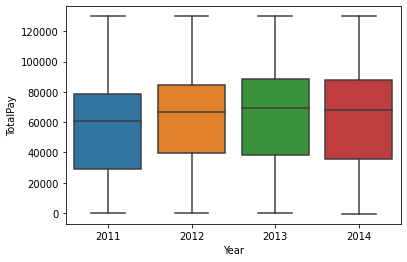

In [52]:
#fig, axes = plt.subplots(1, 1, figsize=(32, 12))
ax = sns.boxplot(x="Year", y="TotalPay", data=sal[(sal.Profession == "TBD")])
plt.show()

In [53]:
pd.pivot_table (sal, index = 'Id', values = 'TotalPay', columns = 'Profession',  aggfunc=np.sum).describe()

Profession,TBD,accountant,"administrator, dph",airport operations supervisor,analyst,architect,assessor,"asst chf prob ofc, juv prob","asst chf, bur clm invest&admin",asst dir clinical svcs 2,...,trans safety specialist,transmission and distribution line worker,transmission line supervisor 1,transmission line supervisor i,transportation,treasurer,trnst power line wrk sprv 2,utility,water const&main supt,welder
count,36254.000000,1010.000000,2.000000,3.000000,4721.000000,1655.000000,4.000000,1.00,2.000000,1.00,...,7.000000,1.00,8.000000,2.000000,10907.000000,4.000000,3.000000,849.000000,4.000000,8.000000
mean,60643.492574,72673.134069,256750.460000,148845.796667,82415.229498,65376.213142,169384.880000,170847.04,144649.245000,141457.64,...,139789.574286,140455.72,166440.937500,151381.155000,69000.242433,169537.992500,175467.503333,95564.950118,171744.620000,145653.845000
std,33454.622477,27113.484656,36584.997752,10264.785963,29656.649652,59424.497097,7018.920394,NaN,4651.001924,NaN,...,5796.113578,NaN,19835.146402,15010.003132,34034.370069,8243.792213,17160.758064,38606.839882,15978.469864,20307.643416
min,-618.130000,70.230000,230880.960000,138875.470000,16.090000,32.290000,164425.000000,170847.04,141360.490000,141457.64,...,132315.430000,140455.72,143452.950000,140767.480000,0.300000,160257.080000,156037.850000,24.520000,149737.920000,130901.280000
25%,36094.585000,59322.792500,243815.710000,143577.865000,67898.010000,12447.760000,165613.382500,170847.04,143004.867500,141457.64,...,136307.180000,140455.72,149868.787500,146074.317500,50119.510000,163856.652500,168925.005000,69183.570000,165088.545000,134193.137500
50%,66223.770000,77272.505000,256750.460000,148280.260000,88687.330000,35902.570000,166677.300000,170847.04,144649.245000,141457.64,...,139215.770000,140455.72,166060.920000,151381.155000,73871.130000,170129.620000,181812.160000,102351.740000,176353.335000,137373.925000
75%,84564.030000,94042.630000,269685.210000,153830.960000,103091.490000,114814.780000,170448.797500,170847.04,146293.622500,141457.64,...,142654.030000,140455.72,178847.820000,156687.992500,87652.175000,175810.960000,185182.330000,123255.790000,183009.410000,146182.355000
max,129996.740000,119516.190000,282619.960000,159381.660000,178813.700000,201803.000000,179759.920000,170847.04,147938.000000,141457.64,...,149073.400000,140455.72,194942.980000,161994.830000,230239.980000,177635.650000,188552.500000,187528.180000,184533.890000,190014.480000


Модель определения Profession по JobTitle на размеченных нами данных

In [54]:
sal.Profession.isna().sum()

0

In [55]:
rs= 12

In [56]:
vectorizer = TfidfVectorizer()

In [57]:
job_vec = vectorizer.fit_transform(sal['JobTitle'])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(job_vec, sal['Profession'], test_size=0.2, random_state=rs)

In [59]:
clf = tree.DecisionTreeClassifier()

In [60]:
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [61]:
pred = clf.predict(X_test)
print('Качество модели по метрике F1', f1_score(y_test,pred,average='weighted'))

Качество модели по метрике F1 0.9949455706529876


Теперь ответим на вопросы в задании

1.	Как со временем менялись зарплаты между разными группами (группировка по Department - fire, medicine, police)? (максимальная, медианная, средняя)


In [62]:
sal_slice = sal.loc[sal.Profession.isin(['fire', 'police', 'medicine'])]

[Text(0.5, 1.0, 'TotalPay')]

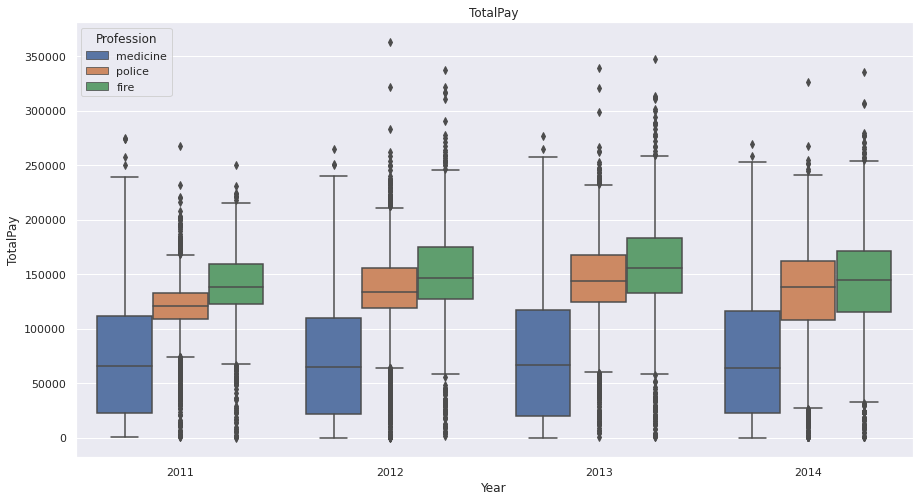

In [63]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(data=sal_slice, x="Year", y="TotalPay",  hue = "Profession").set(title='TotalPay')

1) Из графика видно, что средняя зарплата в сфере медицины в период 2011 - 2014 ниже, чем в полиции и у пожарных. Ниже проверим гипотезу о том, что в медицине средняя зарплата ниже за счет того, что много сотрудников part-time
2) Во всех сферах разброс зарплат большой
3) В полиции и пожарной службе, кроме того, много зарплат, которые определяются как выбросы.
4) Минимальные зарплаты во всех сферах одинаковые - это величина около нуля (по-видимому, опять же, part-time сотрудники)
5)  Максимальные зарплаты в 2011 году были примерно одинаковвые во всех трех сферах, в 2012-2014 максимальные зарплаты в прлиции и пожарной службе стали выше, чем в 2011 году, а у медиков остались примерно на уровне 2011 года.

Ниже информация с графика приведена в табличном виде

In [64]:
def new_col_name(df,newname):
  new_col = []
  for el in df.columns.values: 
    new_col.append((str(el) + newname)) 
  df.columns = new_col
  return df 

medians = pd.pivot_table (sal_slice, index = "Profession", values = 'TotalPay', columns = 'Year',  aggfunc=np.median)
new_col_name(medians, "median")

means = pd.pivot_table (sal_slice, index = "Profession", values = 'TotalPay', columns = 'Year',  aggfunc=np.mean)
new_col_name(means, "mean")
sal_statistic = medians.join(means)

mins = pd.pivot_table (sal_slice, index = "Profession", values = 'TotalPay', columns = 'Year',  aggfunc=np.min)
new_col_name(mins, "min")
sal_statistic = sal_statistic.join(mins)

maxs = pd.pivot_table (sal_slice, index = "Profession", values = 'TotalPay', columns = 'Year',  aggfunc=np.max)
new_col_name(maxs, "max")
sal_statistic = sal_statistic.join(maxs)

counts =  pd.pivot_table (sal_slice[["Year", "Profession"]].value_counts().reset_index(), index = "Profession", values = 0, columns = 'Year',  aggfunc=np.median)
new_col_name(counts, "emp_count")
sal_statistic = sal_statistic.join(counts)
sal_statistic

,2011median,2012median,2013median,2014median,2011mean,2012mean,2013mean,2014mean,2011min,2012min,2013min,2014min,2011max,2012max,2013max,2014max,2011emp_count,2012emp_count,2013emp_count,2014emp_count
Profession,,,,,,,,,,,,,,,,,,,,
fire,137867.255,146499.880,155441.660,144783.775,135605.359114,144334.365686,152600.713904,139659.745614,5.80,963.87,620.23,73.33,250317.93,337204.86,347102.32,335484.96,1118,1129,1145,1188
medicine,65532.700,64291.625,66393.385,64202.250,68931.156777,68475.207035,71525.735541,70769.861537,39.32,3.28,22.57,6.00,274550.25,264364.82,276831.50,268946.02,3863,4628,4714,4748
police,120538.460,133475.775,143316.240,138599.380,116398.205938,128698.997080,138488.224205,130986.395683,101.75,21.98,167.03,55.46,267992.59,362844.66,339282.07,326716.76,1945,2620,2640,2687


2.	Как распределяются базовая оплата, сверхурочная работа и льготы между разными группами? Нужно построить диаграммы по распределению со временем для каждого департамента по базовым, сверхурочным и льготам

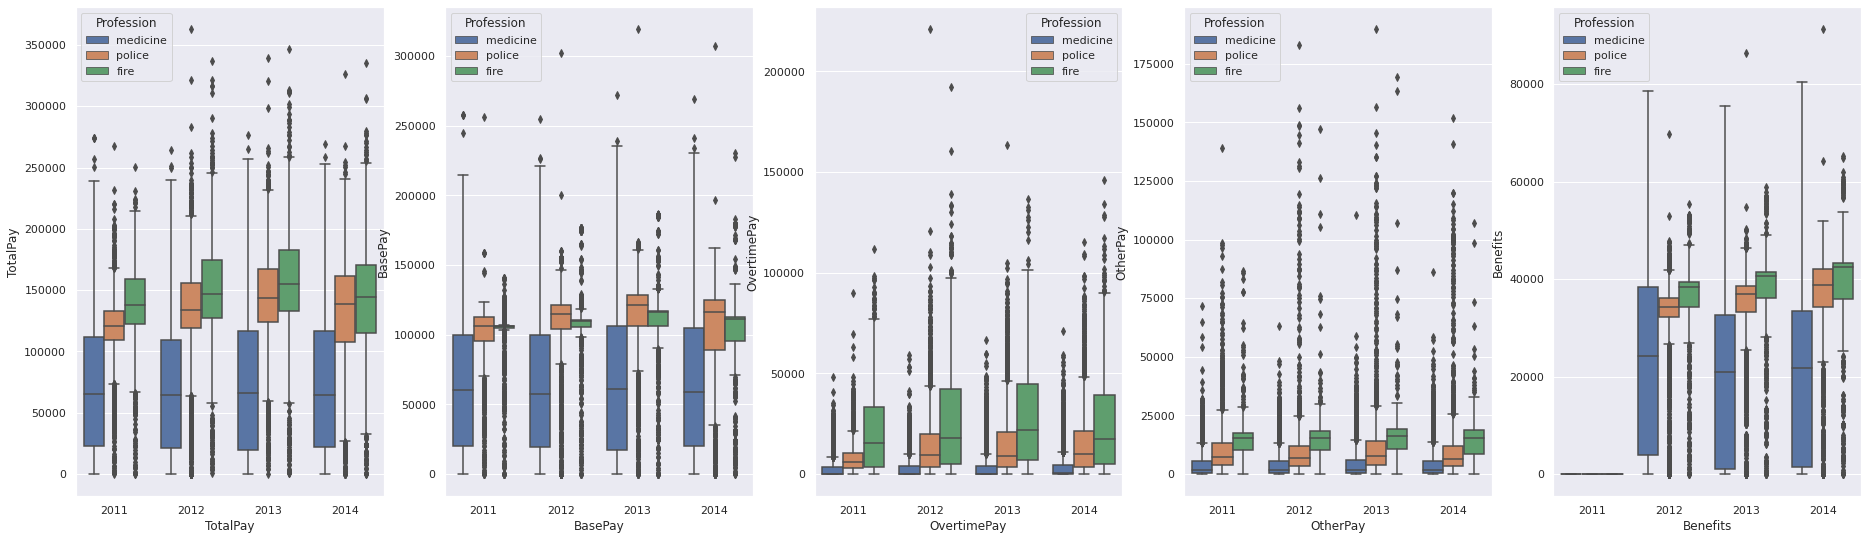

In [65]:
fig, axes = plt.subplots(1, 5, figsize=(32, 9))

sns.boxplot(data=sal_slice, x="Year", y="TotalPay",  hue = "Profession", ax=axes[0]).set(xlabel='TotalPay')
sns.boxplot(data=sal_slice, x="Year", y="BasePay",  hue = "Profession", ax=axes[1]).set(xlabel='BasePay')
sns.boxplot(data=sal_slice, x="Year", y="OvertimePay",  hue = "Profession", ax=axes[2]).set(xlabel='OvertimePay')
sns.boxplot(data=sal_slice, x="Year", y="OtherPay",  hue = "Profession", ax=axes[3]).set(xlabel='OtherPay')
sns.boxplot(data=sal_slice, x="Year", y="Benefits",  hue = "Profession", ax=axes[4]).set(xlabel='Benefits')
plt.show()

3.	Как распределяется бюджет на разные группы (department) с течением времени?

In [66]:
budget = sal_slice.groupby(['Year', 'Profession'])['TotalPay'].sum().reset_index()

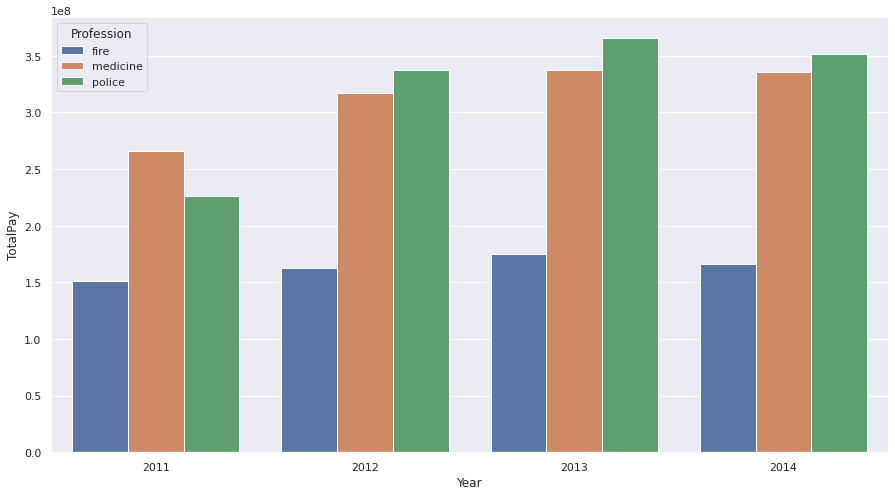

In [67]:
ax = sns.barplot(x="Year", y="TotalPay", data=budget, hue = 'Profession')

4.	Какое количество людей в каждом департаменте? 

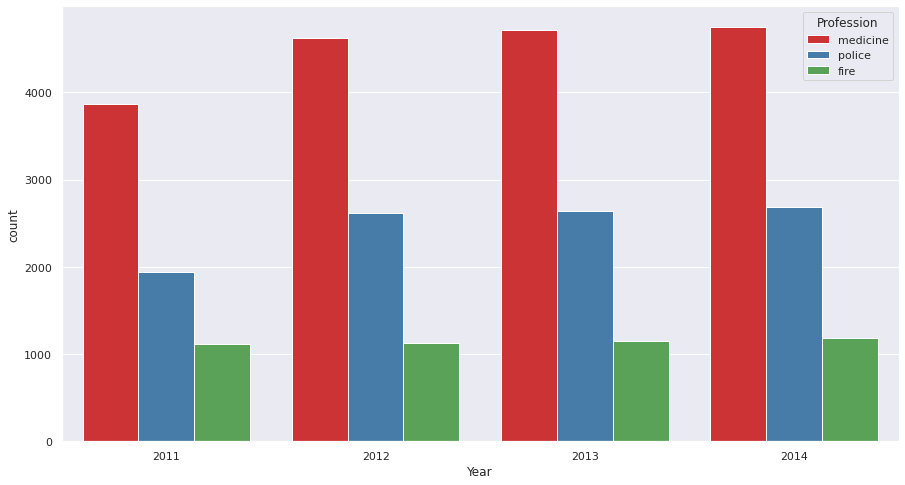

In [68]:
ax = sns.countplot(x="Year", hue="Profession", data=sal_slice, palette="Set1")

Выше хотели проверить, действительно ли среди медиков больше сотрудников part-time. Из графика ниже видно, что это действительно так

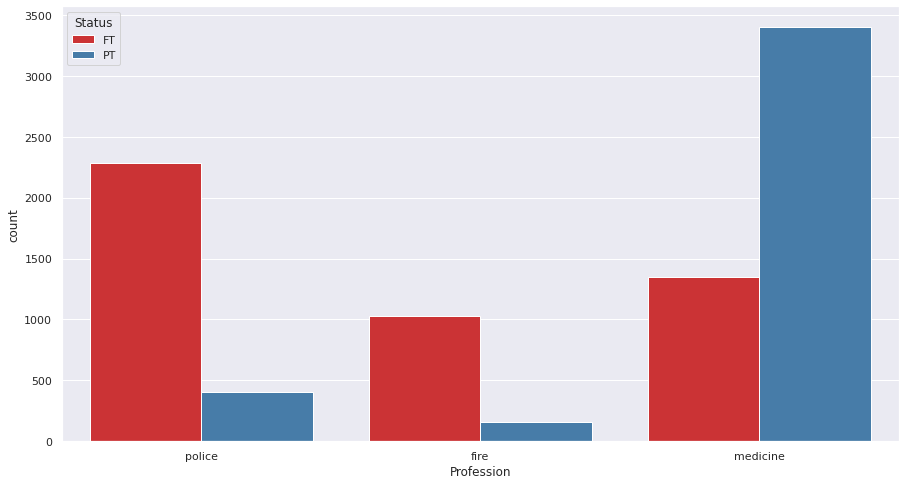

In [69]:
sns.countplot(x="Profession", hue="Status", data=sal_slice.loc[sal_slice.Year == 2014], palette="Set1")

5.	Какое количество с разным уровнем дохода? (гистограмма с шагом в 5к) 

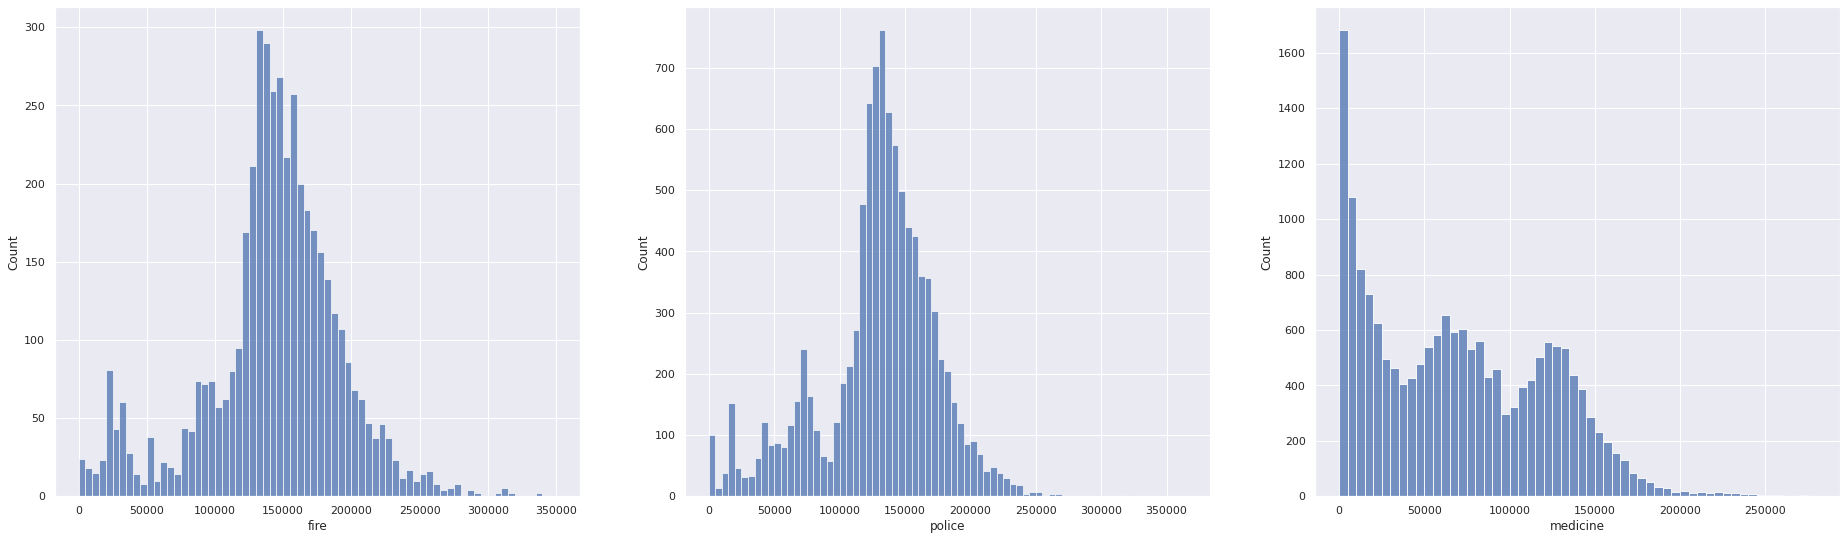

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(32, 9))

sns.histplot(data=sal_slice.loc[sal_slice.Profession == "fire"], x="TotalPay", binwidth=5000, ax=axes[0]).set(xlabel='fire')
sns.histplot(data=sal_slice.loc[sal_slice.Profession == "police"], x="TotalPay", binwidth=5000, ax=axes[1]).set(xlabel='police')
sns.histplot(data=sal_slice.loc[sal_slice.Profession == "medicine"], x="TotalPay", binwidth=5000, ax=axes[2]).set(xlabel='medicine')
plt.show()

6.	На базе линейной регрессии постройте прогноз по тому, какие будут закупке в следующий год по каждому департаменту

In [71]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

In [72]:
dummies = pd.get_dummies(budget.Profession, prefix='Prof')
budget = budget.join(dummies)

In [73]:
budget.head(3)

,Year,Profession,TotalPay,Prof_fire,Prof_medicine,Prof_police
0,2011,fire,1.516068e+08,1,0,0
1,2011,medicine,2.662811e+08,0,1,0
2,2011,police,2.263945e+08,0,0,1


In [74]:
X = budget.drop(['Profession', 'TotalPay'], axis = 1)
y = budget.TotalPay
reg = lin.fit(X.values, y)

In [75]:
print ('Prediction for year 2015 budget for ', dummies.columns.values[0], ': ', '%.2e' % lin.predict([[2015,  1,0,0]])[0])
print ('Prediction for year 2015 budget for ', dummies.columns.values[1], ': ', '%.2e' % lin.predict([[2015,  0,1,0]])[0])
print ('Prediction for year 2015 budget for ', dummies.columns.values[2], ': ', '%.2e' % lin.predict([[2015,  0,0,1]])[0])

Prediction for year 2015 budget for  Prof_fire :  2.21e+08
Prediction for year 2015 budget for  Prof_medicine :  3.72e+08
Prediction for year 2015 budget for  Prof_police :  3.78e+08


In [76]:
budget[[	'Year',	'Profession',	'TotalPay']]

,Year,Profession,TotalPay,Prof_fire,Prof_medicine,Prof_police
0,2011,fire,1.516068e+08,1,0,0
1,2011,medicine,2.662811e+08,0,1,0
2,2011,police,2.263945e+08,0,0,1
3,2012,fire,1.629535e+08,1,0,0
4,2012,medicine,3.169033e+08,0,1,0
5,2012,police,3.371914e+08,0,0,1
6,2013,fire,1.747278e+08,1,0,0
7,2013,medicine,3.371723e+08,0,1,0
8,2013,police,3.656089e+08,0,0,1
9,2014,fire,1.659158e+08,1,0,0


In [92]:
budget.TotalPay.astype('float')

0     1.516068e+08
1     2.662811e+08
2     2.263945e+08
3     1.629535e+08
4     3.169033e+08
5     3.371914e+08
6     1.747278e+08
7     3.371723e+08
8     3.656089e+08
9     1.659158e+08
10    3.360153e+08
11    3.519604e+08
Name: TotalPay, dtype: float64

In [93]:
budget_sum = pd.pivot_table(budget, values=['TotalPay'], index=['Profession'],
                    columns=['Year'], aggfunc=np.sum)

In [112]:
budget_sum['TotalPay']

Year,2011,2012,2013,2014
Profession,,,,
fire,1.516068e+08,1.629535e+08,1.747278e+08,1.659158e+08
medicine,2.662811e+08,3.169033e+08,3.371723e+08,3.360153e+08
police,2.263945e+08,3.371914e+08,3.656089e+08,3.519604e+08


In [115]:
pd.DataFrame({'2011':['1.52e+08', '2.66e+08', '2.26e+08'], '2012': ['1.63e+08', '3.17e+08', '3.37e+08'],'2013': ['1.75e+08', '3.37e+08', '3.66e+08'], '2014':['1.66e+08', '3.36e+08', '3.52e+08']}, index = ['fire', 'medicine', 'police'])

,2011,2012,2013,2014
fire,1.52e+08,1.63e+08,1.75e+08,1.66e+08
medicine,2.66e+08,3.17e+08,3.37e+08,3.36e+08
police,2.26e+08,3.37e+08,3.66e+08,3.52e+08
